In [2]:
import os
import glob
import librosa
import soundfile as sf
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install --upgrade torch

In [1]:
import tensorflow as tf
import keras
import torch
from keras import layers, models ,Model ,Input
from keras.layers import Dense, Flatten, Activation, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [3]:
torch.cuda.is_available()

True

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
Train_Dir = '/content/gdrive/MyDrive/VoiceRecognition/data/Train/'
Test_Dir = '/content/gdrive/MyDrive/VoiceRecognition/data/Test/'

In [6]:
def MFCC(audio_path):
  path = audio_path
  sample_rate = 16000

  x = librosa.load(path,sample_rate)[0]
  S = librosa.feature.melspectrogram(x, sr=sample_rate, n_mels=128)
  log_S = librosa.power_to_db(S, ref=np.max)
  mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=20)

  delta2_mfcc = librosa.feature.delta(mfcc, order=2)

  return mfcc, delta2_mfcc

In [7]:
def padding(list,*array) :
 max = 0
 for i in range(len(list)):
    if max == 0 or list[i].shape[1] > max :
      max = list[i].shape[1]
 for i in range(len(list)):
   addnum = max - list[i].shape[1]
   list[i] = np.pad(list[i], [(0, 0), (0, addnum)], mode='constant')
 for i in array:
   for j in range(len(list)):
     if str(type(i)) == "<class 'numpy.ndarray'>" :
       addnum = i[0].shape[1] - list[j].shape[1]
       if addnum >= 0:
         list[j] = np.pad(list[j], [(0, 0), (0, addnum)], mode='constant')
       else :
         list[j] = list[j][:,0:i[0].shape[1]]
     elif str(type(i)) == "<class 'keras.engine.keras_tensor.KerasTensor'>" :
       addnum = i.shape[2] - list[j].shape[1]
       if addnum >= 0:
         list[j] = np.pad(list[j], [(0, 0), (0, addnum)], mode='constant')
       else :
         list[j] = list[j][:,0:i.shape[2]]

In [ ]:
class Data_augmentation:
  def __init__(self, filepath, num):
    self.filepath = filepath
    self.num = num
  def whiteNoise(self, signal, noise_rate):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_rate
    return augmented_signal
  def timeStretch(self, signal, stretch_rate):
    return librosa.effects.time_stretch(signal, stretch_rate)
  def pitchScaling(self, signal, sr, pitch_step):
    return librosa.effects.pitch_shift(signal, sr, pitch_step)
  def reverse(self, signal):
    return signal * -1

In [ ]:
data = []
target = []

for i, (root, dirs, files) in enumerate (os.walk(Train_Dir)):
  for file in files :
    if '.wav'  not in file in file :
      continue
    else :
      audio_path = os.path.join(root,file)
      mfcc, delta = MFCC(audio_path)
      mfcc = mfcc.astype(float)
      dirname = os.path.dirname(audio_path) 
      data.append(mfcc)
      target.append(dirname)

In [ ]:
padding(data)
data = np.array(data)

encoder = LabelEncoder()
encoder.fit(target)
target_encoded = encoder.transform(target)
print(target, '==>', target_encoded)

target = tf.keras.utils.to_categorical(np.array(target_encoded))

['/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecognition/data/Train/zzds0028', '/content/gdrive/MyDrive/VoiceRecogniti

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.4, shuffle=True, stratify=target, random_state=42)
test_x, val_x, test_y, val_y = train_test_split(val_x, val_y, random_state=42, test_size=0.5, stratify=val_y)

In [ ]:
print('train_x type :', type(train_x), 'train_y type', type(train_y))
print('test_x type :', type(test_x), 'test_y type', type(test_y))
print('train_x shape :', train_x.shape, 'train_y shape', train_y.shape)
print('test_x shape :', test_x.shape, 'test_y shape', test_y.shape)
print('val_x shape :', val_x.shape, 'val_y shape', val_y.shape)

train_x type : <class 'numpy.ndarray'> train_y type <class 'numpy.ndarray'>
test_x type : <class 'numpy.ndarray'> test_y type <class 'numpy.ndarray'>
train_x shape : (1200, 20, 262) train_y shape (1200, 20)
test_x shape : (400, 20, 262) test_y shape (400, 20)
val_x shape : (400, 20, 262) val_y shape (400, 20)


In [ ]:
train_x = np.expand_dims(train_x, -1)
test_x = np.expand_dims(test_x, -1)
val_x = np.expand_dims(val_x, -1)

In [ ]:
# hyper parameters

# learning_rate = 
# epochs = 100
# batch_size = 32

In [ ]:
def CNN(train_x):   
    input = Input(shape=train_x[0].shape)
    
    hidden1 = layers.Conv2D(32, (3, 3), padding='same',strides = (2,2),activation='relu')(input)

    hidden2 = layers.Conv2D(32*2, (3, 3), padding='same',strides = (2,2), activation='relu')(hidden1)
    
    hidden3 = layers.Conv2D(32*3, (3, 3), padding='same',strides = (2,2),activation='relu')(hidden2)

    hidden4 = layers.Conv2D(32*4, (3, 3), padding='same',strides = (2,2),activation='relu')(hidden3)

    hidden5 = layers.Conv2D(32*5, (3, 3), padding='same',strides = (2,2),activation='relu')(hidden4)

    hidden = Flatten()(hidden5)
    hidden = layers.BatchNormalization()(hidden)
    hidden = Dense(32, activation='relu')(hidden)

    output = Dense(20, activation='softmax')(hidden)

    model = Model(input, output)

    return model

In [ ]:
model = CNN(train_x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 262, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 10, 131, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 66, 64)         18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 33, 96)         55392     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 17, 128)        110720    
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 9, 160)         184480    
                                                                 
 flatten (Flatten)           (None, 1440)              0     

In [ ]:
# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
#                                            patience=10),
#              keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/model/best_model.h5',
#                                              monitor='val_loss',
#                                              save_best_only=True,
#                                              include_top= False)]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hist = model.fit(train_x,
          train_y,
          epochs=50,
          batch_size=32,
          verbose=1,
          validation_data=(val_x, val_y),
          callbacks = callbacks)

#model2 = models.load_model('/content/gdrive/MyDrive/model/best_model.h5')

Epoch 1/50
38/38 [==============================] - 9s 183ms/step - loss: 1.8224 - accuracy: 0.4658 - val_loss: 5.3783 - val_accuracy: 0.1275
Epoch 2/50
38/38 [==============================] - 5s 142ms/step - loss: 0.4789 - accuracy: 0.9058 - val_loss: 0.7868 - val_accuracy: 0.7625
Epoch 3/50
38/38 [==============================] - 5s 143ms/step - loss: 0.1421 - accuracy: 0.9792 - val_loss: 0.2131 - val_accuracy: 0.9700
Epoch 4/50
38/38 [==============================] - 6s 146ms/step - loss: 0.0503 - accuracy: 0.9942 - val_loss: 0.1048 - val_accuracy: 0.9775
Epoch 5/50
38/38 [==============================] - 5s 144ms/step - loss: 0.0195 - accuracy: 0.9992 - val_loss: 0.1038 - val_accuracy: 0.9800
Epoch 6/50
38/38 [==============================] - 6s 146ms/step - loss: 0.0123 - accuracy: 0.9983 - val_loss: 0.0666 - val_accuracy: 0.9875
Epoch 7/50
38/38 [==============================] - 5s 140ms/step - loss: 0.0151 - accuracy: 0.9992 - val_loss: 0.1045 - val_accuracy: 0.9750
Epoch 

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)
print(data.shape)
data2 = np.expand_dims(data, -1)
print(data2[880][0].shape)
cvscores = []
for train, test in kfold.split(data2, target):
  model2 = CNN(data2[train])
  model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
  print(target[train].shape)
  hist2 = model2.fit(data2[train],
          target[train],
          epochs=100,
          batch_size=32,
          verbose=1,
          validation_data=(data2[test], target[test]))
  
  scores = model.evaluate(data2[test], target[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

(1300, 20, 262)
(262, 1)
(1040, 13)
Epoch 1/100


ValueError: ignored

In [ ]:
score = model.evaluate(val_x, val_y, verbose=2)
print('Accuracy=',score[1],'Loss=',score[0])

13/13 - 0s - loss: 0.0302 - accuracy: 0.9925 - 381ms/epoch - 29ms/step
Accuracy= 0.9925000071525574 Loss= 0.030201036483049393


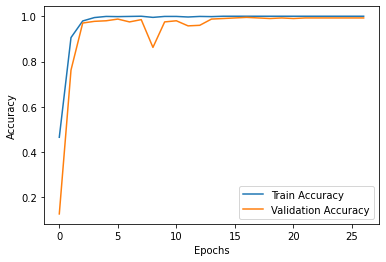

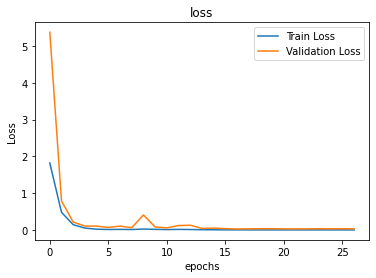

In [ ]:
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_eval(test_y, pred):
  confusion = confusion_matrix(test_y, pred)
  accuracy = accuracy_score(test_y, pred)
  pre_macro = precision_score(test_y, pred, average='macro')
  pre_micro = precision_score(test_y, pred, average='micro')
  recall_macro = recall_score(test_y, pred, average='macro')
  recall_micro = recall_score(test_y, pred, average='micro')
  f1macro = f1_score(test_y, pred, average='macro')
  f1micro = f1_score(test_y, pred, average='micro')

  print('Confusion Matrix')
  print(confusion)
  print('Accuracy:{}' .format(accuracy))
  print('Precision(Macro):{}, Recall(Macro):{}'.format(pre_macro, recall_macro))
  print('Precision(Micro):{}, Recall(Micro):{}'.format(pre_micro, recall_micro))
  print('F1-Score(Macro) : {}, F1-Score(Micro) : {}' .format(f1macro, f1micro))

In [ ]:
pred =np.argmax(model.predict(test_x) , axis=-1)
test_y2 = np.argmax(test_y, axis=-1)

In [ ]:
print('test_y type :', type(test_y2), 'pred type', type(pred))
get_eval(test_y2, pred)

test_y type : <class 'numpy.ndarray'> pred type <class 'numpy.ndarray'>
Confusion Matrix
[[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 

In [ ]:
base_model = models.load_model('/content/gdrive/MyDrive/model/best_model.h5')

record = '/content/gdrive/MyDrive/VoiceRecognition/data/Recording/'
record_list = os.listdir(record) 

print (len(record_list), record_list)
reDir = []

for (root, dirs, files) in os.walk(record):
  for dir in dirs :
    if '.ipynb_checkpoints'  not in dir in dir :
      print(dir)
      print(record + dir)
      reDir.append(record + dir)
print(reDir)
print(record_list)
for i in range (len(reDir)):
  for file in os.listdir(reDir[i]):
    aug = Data_augmentation(reDir[i], 200)
    if '.ipynb_checkpoints'  not in file in file :
      signal, sr = librosa.load(reDir[i] + '/' + file)
      sr = 16000
      print(reDir[i] + '/' + file)
      for j in range(50) :
        aug_signal = aug.whiteNoise(signal, j)
        sf.write(reDir[i] + '/' + "augmented" + str(j) + ".wav", aug_signal, sr)
      for j in range(50) :
        k = j + 50
        aug_signal = aug.timeStretch(signal, j+1)
        sf.write(reDir[i] + '/' + "augmented" + str(k) + ".wav", aug_signal, sr)
      for j in range(50) :
        k = j + 100
        aug_signal = aug.pitchScaling(signal, sr, j)
        sf.write(reDir[i] + '/' + "augmented" + str(k) + ".wav", aug_signal, sr)
      for j in range(50) :
        k = j + 150
        aug_signal = aug.reverse(signal)
        sf.write(reDir[i] + '/' + "augmented" + str(k) + ".wav", aug_signal, sr)

4 ['zzds0658', 'zzds0623', '홍길동20male', '홍길11male']
zzds0658
/content/gdrive/MyDrive/VoiceRecognition/data/Recording/zzds0658
zzds0623
/content/gdrive/MyDrive/VoiceRecognition/data/Recording/zzds0623
홍길동20male
/content/gdrive/MyDrive/VoiceRecognition/data/Recording/홍길동20male
홍길11male
/content/gdrive/MyDrive/VoiceRecognition/data/Recording/홍길11male
['/content/gdrive/MyDrive/VoiceRecognition/data/Recording/zzds0658', '/content/gdrive/MyDrive/VoiceRecognition/data/Recording/zzds0623', '/content/gdrive/MyDrive/VoiceRecognition/data/Recording/홍길동20male', '/content/gdrive/MyDrive/VoiceRecognition/data/Recording/홍길11male']
['zzds0658', 'zzds0623', '홍길동20male', '홍길11male']
/content/gdrive/MyDrive/VoiceRecognition/data/Recording/zzds0658/zzds0658-1000-01-02-HMM-F-04-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Recording/zzds0658/zzds0658-998-01-02-HMM-F-04-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Recording/zzds0658/zzds0658-999

KeyboardInterrupt: ignored

In [ ]:
record_data = []
record_target = []

for i, (root, dirs, files) in enumerate (os.walk(record)):
  for file in files :
    if '.wav'  not in file in file :
      continue
    else :
      audio_path = os.path.join(root,file)
      mfcc, delta = MFCC(audio_path)
      mfcc = mfcc.astype(float)
      dirname = os.path.dirname(audio_path) 
      record_data.append(mfcc)
      record_target.append(dirname)

padding(record_data,base_model.input)
record_data = np.array(record_data)

re_encoder = LabelEncoder()
re_encoder.fit(record_target)
retarget_encoded = re_encoder.transform(record_target)
print(record_target, '==>', retarget_encoded)

record_target = tf.keras.utils.to_categorical(np.array(retarget_encoded))

rectrain_x, recval_x, rectrain_y, recval_y = train_test_split(record_data, record_target, test_size=0.4, shuffle=True, stratify=record_target, random_state=42)
rectrain_x = np.expand_dims(rectrain_x, -1)
recval_x = np.expand_dims(recval_x, -1)
print("record train size : ",rectrain_x.shape[0])

net = Dense(len(record_list), activation='softmax')(base_model.layers[-2].output)
model2 = Model(inputs = base_model.input, outputs = net)

model2.summary()

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hist2 = model2.fit(rectrain_x,
          rectrain_y,
          epochs=50,
          batch_size=32,
          verbose=1,
          validation_data=(recval_x, recval_y),
          )

Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 8.6542 - accuracy: 0.0000e+00 - val_loss: 4.5419 - val_accuracy: 0.2000
Epoch 2/50
1/1 [==============================] - 0s 69ms/step - loss: 3.3833 - accuracy: 0.5000 - val_loss: 2.6622 - val_accuracy: 0.4000
Epoch 3/50
1/1 [==============================] - 0s 79ms/step - loss: 0.6094 - accuracy: 0.6667 - val_loss: 2.2085 - val_accuracy: 0.6000
Epoch 4/50
1/1 [==============================] - 0s 70ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 2.2475 - val_accuracy: 0.4000
Epoch 5/50
1/1 [==============================] - 0s 76ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 2.3458 - val_accuracy: 0.4000
Epoch 6/50
1/1 [==============================] - 0s 77ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 2.4893 - val_accuracy: 0.4000
Epoch 7/50
1/1 [==============================] - 0s 66ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 2.5614 - val_accuracy: 0.4000
Epoch 8/50
1/1 [=========

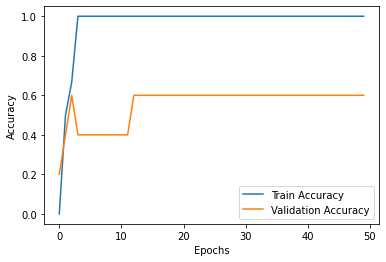

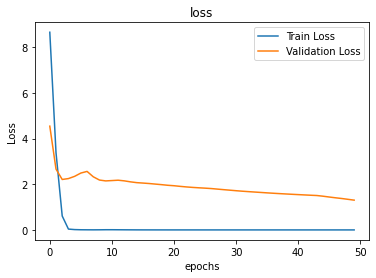

In [ ]:
plt.plot(hist2.history['accuracy'], label='Train Accuracy')
plt.plot(hist2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(hist2.history['loss'], label='Train Loss')
plt.plot(hist2.history['val_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('loss')
plt.legend()
plt.show()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20, 262, 1)]      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 10, 131, 32)       320       
                                                                 
 conv2d_26 (Conv2D)          (None, 5, 66, 64)         18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 3, 33, 96)         55392     
                                                                 
 conv2d_28 (Conv2D)          (None, 2, 17, 128)        110720    
                                                                 
 conv2d_29 (Conv2D)          (None, 1, 9, 160)         184480    
                                                                 
 flatten_5 (Flatten)         (None, 1440)              0  

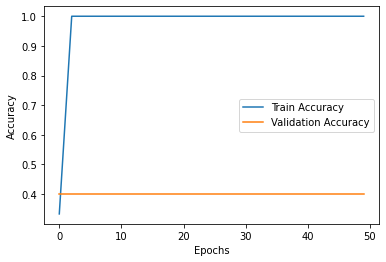

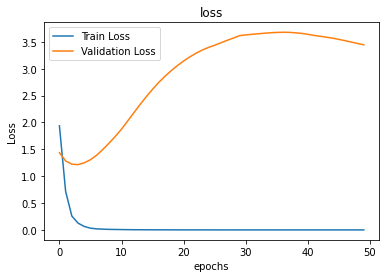

In [ ]:
model3 = CNN(rectrain_x)
model3.save("/content/gdrive/MyDrive/model/test3_model.h5")
model3 = models.load_model("/content/gdrive/MyDrive/model/test3_model.h5")
net = Dense(len(record_list), activation='softmax')(model3.layers[-2].output)
model3 = Model(inputs = model3.input, outputs = net)
model3.summary()

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

hist3 = model3.fit(rectrain_x,
          rectrain_y,
          epochs=50,
          batch_size=32,
          verbose=1,
          validation_data=(recval_x, recval_y),
          )

plt.plot(hist3.history['accuracy'], label='Train Accuracy')
plt.plot(hist3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(hist3.history['loss'], label='Train Loss')
plt.plot(hist3.history['val_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
test = []

for i, (root, dirs, files) in enumerate (os.walk(Test_Dir)):
  for file in files :
    if '.wav'  not in file in file :
      continue
    else :
      audio_path = os.path.join(root,file)
      print(audio_path)
      mfcc, delta = MFCC(audio_path)
      mfcc = mfcc.astype(float)
      test.append(mfcc)

print(test[0].shape)
padding(test,train_x)
test = np.array(test)
print(test.shape)

test = np.expand_dims(test, -1)

pred = np.argmax(model.predict(test), axis=-1)
print(pred)


/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0623-897-01-02-JEC-F-03-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0623-899-01-02-JEC-F-03-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0623-895-01-02-JEC-F-03-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0623-892-01-02-JEC-F-03-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0623-894-01-02-JEC-F-03-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0623-898-01-02-JEC-F-03-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0623-896-01-02-JEC-F-03-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0623-893-01-02-JEC-F-03-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0658-997-01-02-HMM-F-04-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0658-996-01-02-HMM-F-04-D.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0433-41-01-03-LJY-F-04-C.wav
/content/gdrive/MyDrive/VoiceRecognition/data/Test/zzds0259-62-01-

In [ ]:
test2 = []
Dirs = '/content/gdrive/MyDrive/GSF03031LJH0_한국어/'
files = os.listdir(Dirs)

for filename in files:
    if '.wav' not in filename in filename:
      continue
    else :
      audio_path2 = Dirs + filename
      mfcc2, delta2 = MFCC(audio_path2)
      mfcc2 = mfcc2.astype(float)
      test2.append(mfcc2)

print(test2[0].shape)
padding(test2,train_x)
test2 = np.array(test2)
print(test2[0].shape)


test2 = np.expand_dims(test2, -1)

pred22 = model.predict(test2)
pred2 = np.argmax(model.predict(test2), axis=-1)
pred3 = np.argmax(model.predict(test2>0.5).astype("int32"))
print(pred2)
print(pred22)
print(pred3)

(20, 212)
(20, 262)
[12 12 12 12 12 18 12 12 12 18]
[[3.93024102e-08 1.17781329e-14 1.33007370e-06 1.04463361e-07
  5.29101448e-13 9.38403417e-08 1.69311934e-05 1.39471351e-10
  3.43406862e-13 5.66886023e-08 6.55917859e-07 8.90440013e-11
  7.85475910e-01 1.23069244e-09 8.85577690e-14 1.52352118e-06
  3.96086159e-16 1.57363331e-06 2.14501783e-01 1.41595924e-09]
 [4.27491997e-09 2.96264663e-17 1.24967880e-06 2.25407419e-07
  3.70779830e-14 4.12533652e-09 7.39765164e-05 1.30351945e-11
  5.39490802e-14 1.98221040e-09 6.38901057e-08 1.01554160e-12
  9.76180971e-01 3.79087955e-10 1.92309534e-15 7.65791199e-08
  5.17753563e-18 6.43983284e-08 2.37433445e-02 5.23267332e-11]
 [4.01958605e-10 2.25549561e-19 6.81528860e-08 1.08437523e-10
  1.03456968e-18 1.21575652e-10 4.42599372e-07 4.88499161e-13
  7.56504861e-15 8.81980513e-12 1.25934074e-09 1.88779940e-16
  9.95484233e-01 7.54799435e-12 1.42268138e-18 2.73605405e-09
  5.53367997e-20 1.45067880e-09 4.51536849e-03 2.20641734e-12]
 [4.44579840e-0